### Tratamento de Dados Qualidade de Água HIDROWEB - RNQA
Fluxo Geral
1) Encontrar estações desejadas a partir do shape de pontos da RNQA e shapefile da área de interesse
2) Obter lista de estações de interesse
3) Gera lista de links das estações de interesse0
4) Baixar dados do Hidroweb
5) A partir de pasta de dados baixados do HIDROWEB, consolida os registros em uma base única

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Carregando os Shapefiles de Interesse
- Pontos da RNQA em 2020: Catálogo de Metadados da ANA (https://metadados.snirh.gov.br/geonetwork/srv/por/catalog.search#/metadata/7470ba67-b0c1-440c-af4c-e2ac4eadac95)
- Área de Interesse: Exemplo - Porção Capixaba da Bacia Hidrográfica do Rio São Mateus (https://metadados.snirh.gov.br/geonetwork/srv/api/records/3c0e0c20-f6ae-4e3b-bb95-b27b61fdbbd8/attachments/plnft_comite_bacia_estadual.zip) 

In [2]:
## Carregando pontos e área de interesse
pontos_rnqa = gpd.read_file('C:/Users/frori/Documents/Quali_ANA/SHP/RNQA_2020_setembro.shp') ## informe onde você salvou o shp da RNQA
area_of_interest = gpd.read_file('C:/Users/frori/Documents/Quali_ANA/SHP/SM_ES.shp') ## Informe onde você salvou o shp da sua área de interesse

## Verificando se o Sistema de Referência de Coordenadas é compatível!
if pontos_rnqa.crs == area_of_interest.crs:
    print("Os SRC são iguais, podemos continuar!")
else:
    pontos_rnqa = pontos_rnqa.to_crs("EPSG:4674")
    area_of_interest = area_of_interest.to_crs("EPSG:4674")
    print("Os SRC eram diferentes, foram reprojetados para SIRGAS 2000 (EPSG: 4674), podemos continuar!")

Os SRC são iguais, podemos continuar!


<AxesSubplot:title={'center':'Pontos da RNQA na Área de Interesse (6 pontos)'}>

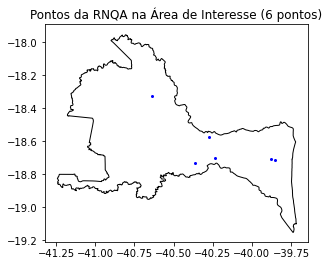

In [3]:
## Recortando os pontos dentro da área de interesse
pontos_aoi = gpd.clip(pontos_rnqa, area_of_interest)

## Exporta o .shp com os pontos recortados
pontos_aoi.to_file(driver = 'ESRI Shapefile', filename = 'C:/Users/frori/Documents/Quali_ANA/SHP/Pontos_RNQA_SM_ES.shp') ## informe aqui o caminho e o nome da pasta de destino

## Plotando os pontos na área de interesse
base = area_of_interest.plot(color = 'white', edgecolor = 'black')
point_n = pontos_aoi['Código_Hi'].nunique()
base.set_title('Pontos da RNQA na Área de Interesse ({} pontos)'.format(point_n))
pontos_aoi.plot(ax = base, marker = 'o', color = 'blue', markersize = 4)

In [5]:
## Pegar Códigos do HIDROWEB e exportando tabela com links para baixar
pontos_aoi_cods = pontos_aoi['Código_Hi'].astype(int).reset_index()
pontos_aoi_cods = pd.DataFrame(pontos_aoi_cods)
pontos_aoi_cods.columns = ['id','cod_ana']
pontos_aoi_cods['link'] = 'https://www.snirh.gov.br/hidroweb/serieshistoricas?codigoEstacao=' + pontos_aoi_cods['cod_ana'].astype(str)
pontos_aoi_cods.to_csv('C:/Users/frori/Documents/Quali_ANA/pontos_aoi_cods.csv') ## INFORME A PASTA DE DESTINO DOS LINKS

### Agora vamos baixar os dados do portal da ANA

- O script criado é baseado no driver do Mozilla Firefox com base no pacote selenium (https://selenium-python.readthedocs.io/)
- É importante definir a pasta de download do Mozilla (no próprio Mozilla) como a pasta desejada para os dados baixados de qualidade de água
- Também é importante que você insira o documento "geckodriver.exe" na pasta onde seu interpretador de Python está salvo (no meu caso, o conda). Esse documento pode ser baixado em: https://github.com/mozilla/geckodriver/releases

In [20]:
## Pega a coluna de urls da ANA e cria uma lista para iterar
url_listed = list(pontos_aoi_cods['link'])

# Carrega Pacotes Necessários
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.firefox.service import Service 

## Itera o download sobre a lista de estações de monitoramento de qualidade
for url in url_listed:
# Cria o driver na url de destino 
    driver = webdriver.Firefox(service = Service(r'C:\Users\frori\Documents\conda\geckodriver.exe')) ## informe a pasta onde está o arquivo do geckodriver.exe
    driver.get(url)
    
    ### Abaixo, executa as ações dentro do site da ANA 
    
    ## get checkbox element
    checkbox1 = driver.find_element("id","mat-checkbox-1")
    # create action chain object
    action = ActionChains(driver)
    # click the item
    action.click(on_element = checkbox1)
    # perform the operation
    action.perform()

    ## get checkbox element
    checkbox2 = driver.find_element("id","mat-radio-4")
    # create action chain object
    action = ActionChains(driver)
    # click the item
    action.click(on_element = checkbox2)
    # perform the operation
    action.perform()

    ## get checkbox element
    download_button = driver.find_element("partial link text", "Baixar Arquivo")
    # create action chain object
    action = ActionChains(driver)
    # click the item
    action.click(on_element = download_button)
    # perform the operation
    action.perform()


MoveTargetOutOfBoundsException: Message: (796, 933) is out of bounds of viewport width (1284) and height (884)
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.jsm:12:1
WebDriverError@chrome://remote/content/shared/webdriver/Errors.jsm:192:5
MoveTargetOutOfBoundsError@chrome://remote/content/shared/webdriver/Errors.jsm:382:5
assertInViewPort@chrome://remote/content/marionette/action.js:1946:11
dispatch@chrome://remote/content/marionette/action.js:1000:21
dispatch/pendingEvents<@chrome://remote/content/marionette/action.js:1691:14
dispatch@chrome://remote/content/marionette/action.js:1690:39
dispatch/chainEvents<@chrome://remote/content/marionette/action.js:1617:27
dispatch@chrome://remote/content/marionette/action.js:1619:7
performActions@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:468:23
receiveMessage@chrome://remote/content/marionette/actors/MarionetteCommandsChild.jsm:145:31


In [16]:
### Carrega os arquivos na Pasta de downloads do Mozilla e os descompacta
import os
import glob
import zipfile

dir_name = r"C:/Users/frori/Documents/Quali_ANA/DATA" ## Aqui é importante definir a pasta configurada no Mozilla para salvar os dados
extension = ".zip"

# Primeira Descompactação

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = dir_name + "/" + item # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file
      
# Segunda Descompactação  
for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = dir_name + "/" + item # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

### Agora vamos abrir os dados da ANA baixados através dos dados baixados acima
- Informar a pasta com os dados
- Abrir os dataframes em uma lista
- Tratar cada um dos dataframes (função)
- Juntar em um só dataframe
- Estatísticas Descritivas

In [18]:
## pegar todos os arquivos .csv da pasta
dir_name = r"C:/Users/frori/Documents/Quali_ANA/DATA"
csv_files = glob.glob(os.path.join(dir_name, '*.csv'))

## seleciona dados de qualidade (caso estação também tenha dados de vazão)
csv_files_qual = []
for file in csv_files:
    len_file = len(file)
    if file[len_file - 23:len_file - 15] == 'qualagua':
        csv_files_qual.append(file)

In [19]:
## Carrega, trata e combina os dados
df_list = list()

## Itera o tratamento de dados sobre as bases baixadas
for file in csv_files_qual:
    ## Carregar dados
    df = pd.read_csv(file, sep = ';', skiprows = 14, decimal = '.', index_col = False)
    df = df[df.columns.drop(list(df.filter(regex = 'QualAgua')))]
    df = df[df.columns.drop(list(df.filter(regex = 'Parametro')))].reset_index()
    df = df.drop(['Hora','NumMedicao','PosHorizColeta','PosVertColeta','Profundidade','NivelConsistencia'], axis = 1)
    
    ## Tratamento de dados
    df['Choveu'] = df['Choveu'].replace('0,0','N').replace('1,0','S')
    df['EstacaoCodigo'] = df['EstacaoCodigo'].round(decimals = 0).astype('str')
    df['Data'] = pd.to_datetime(df['Data'])

    ## Combinar coluna de parâmetros
    df = pd.melt(df, id_vars = df.columns[0:4], value_vars = df.columns[4:df.columns.size-1], var_name = 'parametros',value_name = 'concentracoes')
    df['concentracoes'] = df['concentracoes'].str.replace(',','.').astype('float32')
    df_list.append(df)

## Concatena tudo em uma base
df_estacoes = pd.concat(df_list, axis=0)

## Exporta base para uma planilha (.csv)
df_estacoes.to_csv(r"C:/Users/frori/Documents/Quali_ANA/dados_quali_bacia.csv")

## Mostra o resultado
df_estacoes.head()

,index,EstacaoCodigo,Data,Choveu,parametros,concentracoes
0,0,55860000,2020-06-01,S,TempAr,25.299999
1,1,55860000,2019-07-10,S,TempAr,30.299999
2,2,55860000,2019-01-07,S,TempAr,29.000000
3,3,55860000,2019-01-04,N,TempAr,31.000000
4,4,55860000,2019-07-01,N,TempAr,35.000000
